In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
iphones = pd.read_csv('iphones.csv')
books = pd.read_csv('books.csv')
clothing = pd.read_csv('clothing.csv')
collectables = pd.read_csv('collectables.csv')
healthbeauty = pd.read_csv('healthbeauty.csv')
homegarden = pd.read_csv('homegarden.csv')
music = pd.read_csv('music.csv')
sporting = pd.read_csv('sporting.csv')

In [3]:
iphones.columns

Index(['item_number', ' item_title', ' payment_method', ' postal_code',
       ' shipping_method', ' sales_price', ' selling_state', ' best_offer',
       ' bin_available', ' start_time', ' end_time', ' listing_type',
       ' returns_accepted', ' condition', ' top_rated', ' seller',
       ' feedback_percentage', ' feedback_score', ' description'],
      dtype='object')

In [4]:
dataframes = [
    iphones,
    books,
    clothing,
    collectables,
    healthbeauty,
    homegarden,
    music,
    sporting
]

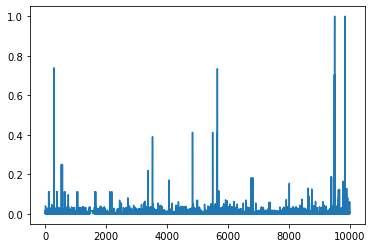

In [5]:
scaler = MinMaxScaler()


for df in dataframes:
    df[' description'] = scaler.fit_transform(df[[' description']])
    
# Test to see scaler applied
collectables[' description']
plt.plot(collectables[' description'])

In [65]:
test = iphones[(iphones[' feedback_score']) < 1 &
        (iphones[' description'] < 0.002) &
        (pd.isnull(iphones[' feedback_percentage']) == True)]

#test[[' start_time', ' end_time']]
test[' start_time'] = pd.to_datetime(test[' start_time'])
test[' end_time'] = pd.to_datetime(test[' end_time'])
test['Diff'] =  test[' end_time'] - test[' start_time']

# test[' start_time'].dtypes
test['Diff']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

21      0 days 02:56:56
38      0 days 00:09:36
43      0 days 01:05:22
47      0 days 03:29:38
55      0 days 09:53:41
              ...      
15342   0 days 00:10:50
15379   0 days 05:55:21
15840   0 days 16:41:31
16030   7 days 19:21:33
16515   0 days 07:52:41
Name: Diff, Length: 553, dtype: timedelta64[ns]

In [7]:
iphone_scams = iphones[(iphones[' feedback_score']) < 1 &
        (iphones[' description'] < 0.002) &
        (pd.isnull(iphones[' feedback_percentage']) == True)]

books_scams = books[(books[' feedback_score']) < 1 &
        (books[' description'] < 0.002) &
        (pd.isnull(books[' feedback_percentage']) == True)]

clothing_scams = clothing[(clothing[' feedback_score']) < 1 &
        (clothing[' description'] < 0.002) &
        (pd.isnull(clothing[' feedback_percentage']) == True)]

collectables_scams = collectables[(collectables[' feedback_score']) < 1 &
        (collectables[' description'] < 0.002) &
        (pd.isnull(collectables[' feedback_percentage']) == True)]

healthbeauty_scams = healthbeauty[(healthbeauty[' feedback_score']) < 1 &
        (healthbeauty[' description'] < 0.002) &
        (pd.isnull(healthbeauty[' feedback_percentage']) == True)]

homegarden_scams = homegarden[(homegarden[' feedback_score']) < 1 &
        (homegarden[' description'] < 0.002) &
        (pd.isnull(homegarden[' feedback_percentage']) == True)]

music_scams = music[(music[' feedback_score']) < 1 &
        (music[' description'] < 0.002) &
        (pd.isnull(music[' feedback_percentage']) == True)]

sporting_scams = sporting[(sporting[' feedback_score']) < 1 &
        (sporting[' description'] < 0.002) &
        (pd.isnull(sporting[' feedback_percentage']) == True)]

In [37]:
iphone_scamrate = len(iphone_scams) / len(iphones)
book_scamrate = len(books_scams) / len(books)
clothing_scamrate = len(clothing_scams) / len(clothing)
collectable_scamrate = len(collectables_scams) / len(collectables)
healthbeauty_scamrate = len(healthbeauty_scams) / len(healthbeauty)
homegarden_scamrate = len(homegarden_scams) / len(homegarden)
music_scamrate = len(music_scams) / len(music)
sporting_scamrate = len(sporting_scams) / len(sporting)

scamrate_list = [
    iphone_scamrate,
    book_scamrate,
    clothing_scamrate,
    collectable_scamrate,
    healthbeauty_scamrate,
    homegarden_scamrate,
    music_scamrate,
    sporting_scamrate,
]

scamrate_list = list(map(lambda x: x * 100, scamrate_list))

In [38]:
print(scamrate_list)

[3.3115755434457155, 0.30120481927710846, 1.6199999999999999, 0.97009700970097, 1.66, 1.52, 0.13, 0.6]


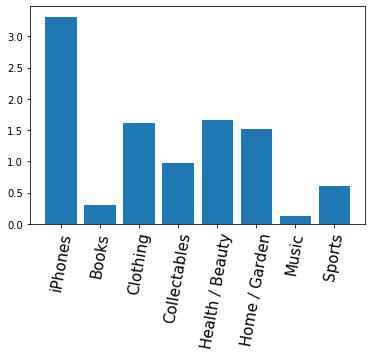

In [56]:
catname_list = [
    'iPhones',
    'Books',
    'Clothing',
    'Collectables',
    'Health / Beauty',
    'Home / Garden',
    'Music',
    'Sports',
]
index = np.arange(len(catname_list))
plt.bar(index, scamrate_list)
plt.xticks(index, catname_list, fontsize=15, rotation=80)
plt.show()